<h1> Are property management companies worth it? </h1>

<h2> An exploratory data analysis of Seattle Airbnb data by Alex Siebel-McKenna </h2>

In [1]:
# Importing requisite packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h3> Gathering the data </h3>

In [2]:
# Loading the listings dataset and availability calendar

seattle_listings = pd.read_csv('seattle_listings.csv')
seattle_calendar = pd.read_csv('seattle_calendar.csv')

<h3> Assessing and cleaning the data </h3>

In [3]:
# Rename 'id' column in seattle_listings to 'listing_id'

seattle_listings.rename({'id':'listing_id'}, axis=1, inplace=True)

In [4]:
# Merging seattle_calendar with seattle_listings[['listing_id', 'host_id']] on 'listing_id'

seattle_calendar = pd.merge(seattle_calendar, seattle_listings[['listing_id', 'host_id']], on='listing_id')

In [5]:
# How many days of data are available for each listing? Can we confirm that there is a year's worth of data for all of them?

try:
    assert(seattle_calendar[['host_id','listing_id', 'date', 'available']].groupby('listing_id').count()['date'].unique()[0]==365)
    print('Balanced data. All listings have 365 rows of availability.')
except:
    print('Unbalanced data! Not all listings have 365 rows of availability.')

Balanced data. All listings have 365 rows of availability.


In [6]:
# Make sure that values in 'id' column are unique (i.e. there are no duplicate listings)

try:
    assert(len(seattle_listings['listing_id'].unique()) == seattle_listings.shape[0])
    print('There are no duplicate listings in seattle_listings.')
except:
    print('Duplicates in seattle_listings detected.')

There are no duplicate listings in seattle_listings.


Renaming the hosts to company names (following links in the host_url column reveals this):

In [7]:
# Rename the hosts using host_id (taken manually from host_url column)

investor_dictionary = {8534462:'Barsala',
                      4962900:'Stay Alfred',
                      1243056:'Grokhome',
                      74305:'Seattle Oasis',
                      658155:'Kenny Properties LLC',
                      31148752:'TurnKey',
                      66145:'The Dexter Experience',
                      30283594:'Global Luxury Suites',
                      1478274:'LiveLikeItsYours'}

# Change the names of hosts with IDs in the investor_dictionary, leave untouched those that aren't 

seattle_listings['host_name'] = seattle_listings['host_id'].map(investor_dictionary).fillna(seattle_listings['host_name'])

# Merge with seattle_calendar to include host_name column

seattle_calendar = pd.merge(seattle_calendar, seattle_listings[['host_id', 'host_name']], on='host_id')

First, we want to find which hosts have greater than 10 properties:

In [8]:
def get_count_by_host_listings_count(df, n=10): #To distinguish from getting the count by the number of rows
    """
    Returns list of hosts with their listings and host_listing_count values
    
    Parameters:
    df: seattle_listings
    n (int): Threshold of host listings count (default 10)
    
    Returns: 
    df_count: Subset of hosts with host_listings_count values > n
    """
    df_count = (df[['host_id','host_name','host_url','host_listings_count']][df['host_listings_count']>n]
                .drop_duplicates('host_id').sort_values(by='host_listings_count', ascending=False))
    return df_count

investor_count = get_count_by_host_listings_count(df=seattle_listings)

original_investor_list_id = investor_count['host_id'].unique()

Plotting this first set of investor hosts:

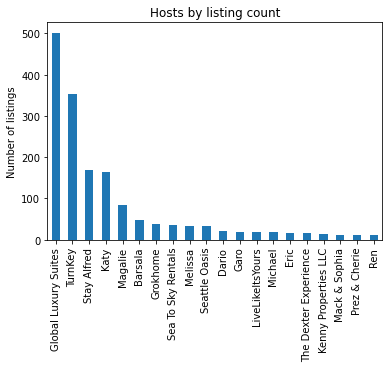

In [9]:
# Plot hosts by host_listing_count

investor_count[['host_name', 'host_listings_count']].plot(kind='bar', legend=None);
x = investor_count['host_name']
x_pos = [i for i, _ in enumerate(x)]
plt.xticks(x_pos, x);
plt.xlabel('');
plt.ylabel('Number of listings');
plt.title('Hosts by listing count');

But are the hosts above adequately represented in seattle_calendar? We can compute a representativeness (R-) index to find out, but first we have to clean the data a little bit more:

In [10]:
def split_dfs(df, lst):
    
    """
    Helper function - splits datasets into separate investor and non-investor datasets.
    
    Parameters:
    df: DataFrame to split (e.g. seattle_listings, seattle_calendar)
    lst (list): list of investor names to split on 
    
    Returns:
    df1, df2: Separate DataFrames split on the list of investor names used
    
    """
    df1 = df[df['host_id'].isin(lst)]
    df2 = df[~df['host_id'].isin(lst)]
    
    return df1, df2

In [11]:
investor_listings, noninvestor_listings = split_dfs(df=seattle_listings, lst=original_investor_list_id)
investor_calendar, noninvestor_calendar = split_dfs(df=seattle_calendar, lst=original_investor_list_id)

In [12]:
num_unique_investor_listings = len(investor_calendar['listing_id'].unique())
num_unique_noninvestor_listings = len(noninvestor_calendar['listing_id'].unique())
num_unique_total_listings = len(seattle_calendar['listing_id'].unique())

try:
    assert(len(noninvestor_calendar['listing_id'].unique()) + len(investor_calendar['listing_id'].unique()) == len(seattle_calendar['listing_id'].unique()))
    print('All listings in seattle_calendar are in either investor_calendar or noninvestor_calendar. \nThere are {} unique listings in investor_calendar, {} unique listings in noninvestor_calendar, giving us {} listings in total.'
         .format(num_unique_investor_listings,num_unique_noninvestor_listings,num_unique_total_listings))
except:
    print('Not all listings in seattle_calendar are in either investor_calendar or noninvestor_calendar.')

All listings in seattle_calendar are in either investor_calendar or noninvestor_calendar. 
There are 352 unique listings in investor_calendar, 3466 unique listings in noninvestor_calendar, giving us 3818 listings in total.


We want value counts of listings by host in investor_calendar - these will become the calculated_host_listings column:

In [13]:
def get_count(df, lst, no_duplicates=True):
    """
    Returns a dataframe containing investor host IDs and names (supplied by lst) and how many listings each has in df
    
    Parameters:
    df: Availability calendar
    lst: List of investors
    no_duplicates: If True, then only unique values (one entry per host)
    
    Returns:
    investor_count_calendar: Count of hosts by listing in seattle_calendar/investor_calendar/noninvestor_calendar
    
    """
    investor_count_calendar = df.groupby('host_id')['listing_id'].nunique().reset_index().rename({'listing_id':'calculated_host_listings'}, axis=1).sort_values(by='calculated_host_listings', ascending=False)
    investor_count_calendar = pd.merge(investor_count_calendar, df[['host_id','host_name']], on='host_id')[['host_id', 'host_name', 'calculated_host_listings']].reset_index(drop=True)
    
    if no_duplicates:
        investor_count_calendar = investor_count_calendar.drop_duplicates(['host_id']).reset_index(drop=True)
    
    return investor_count_calendar

investor_count_calendar = get_count(df=investor_calendar, lst=original_investor_list_id)

Next, we would like to compare the above to a similar DataFrame with the value from 'host_listings_count' (i.e. their total number of listings) to calculate each host's R-index value.

R-index value = (Calculated no. of listings in seattle_calendar)/(Reported value in host_listings_count) $\in$ [0,1]

Slicing a subset of investor_listings so that we can add host_listings_count to the DataFrame created in the previous cell:

In [14]:
investor_listings_count = investor_listings[['host_id', 'host_name', 'host_listings_count']].drop_duplicates('host_id').reset_index(drop=True)

Merging both datasets to compare everything in the same DataFrame:

In [15]:
merged_investor_count_calendar = pd.merge(investor_count_calendar, investor_listings_count[['host_id', 'host_listings_count']], on='host_id')

Calculating the R-index values corresponding to each investor host

In [16]:
merged_investor_count_calendar['r-index'] = merged_investor_count_calendar['calculated_host_listings']/merged_investor_count_calendar['host_listings_count']
merged_investor_count_calendar = merged_investor_count_calendar.sort_values(by='r-index', ascending=False).reset_index(drop=True)
merged_investor_count_calendar.head()

,host_id,host_name,calculated_host_listings,host_listings_count,r-index
0,1623580,Mack & Sophia,12,12.0,1.0
1,2911360,Ren,11,11.0,1.0
2,1243056,Grokhome,37,37.0,1.0
3,430709,Sea To Sky Rentals,36,36.0,1.0
4,3074414,Melissa,34,34.0,1.0


Plotting r-index values by host:

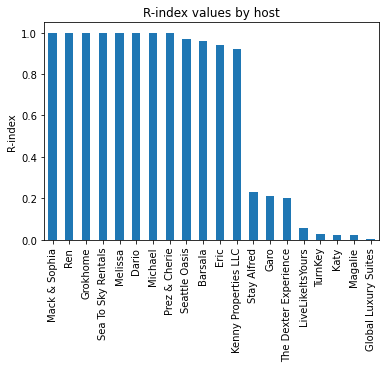

In [17]:
merged_investor_count_calendar[['host_name', 'r-index']].sort_values(by='r-index', ascending=False).plot(kind='bar', legend=None);
x = merged_investor_count_calendar['host_name'];
x_pos = [i for i, _ in enumerate(x)];
plt.xticks(x_pos, x);
plt.xlabel('');
plt.ylabel('R-index');
plt.title('R-index values by host');

Notice the sharp drop in R-index values after about 0.9. It would make sense then to use this as a threshold.

Collecting the new investor host IDs and reconstructing our listings datasets and availability calendars:

In [18]:
# List object containing the listings of the new investor list, with r-index values greater than 0.90
new_investor_list_id = merged_investor_count_calendar['host_id'][merged_investor_count_calendar['r-index']>0.9]

#Re-generating the following DataFrames to reflect the new investor list
investor_listings, noninvestor_listings = split_dfs(df=seattle_listings, lst=new_investor_list_id)

investor_calendar, noninvestor_calendar = split_dfs(df=seattle_calendar, lst=new_investor_list_id)

investor_count_calendar = get_count(df=investor_calendar, lst=new_investor_list_id)

<h3>Visualization</h3>

Plotting this new set of investors:

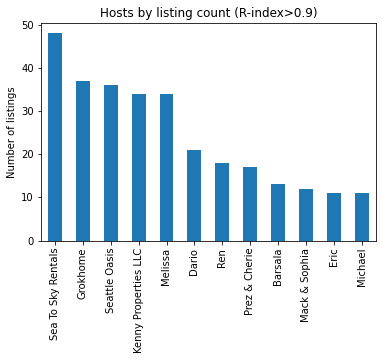

In [19]:
(investor_listings[['host_name', 'host_listings_count']]).drop_duplicates('host_name').sort_values(by='host_listings_count', ascending=False).plot(kind='bar', legend=None);
x = investor_listings['host_name'].unique()
x_pos = [i for i, _ in enumerate(x)]
plt.xticks(x_pos, x);
plt.xlabel('');
plt.ylabel('Number of listings');
plt.title('Hosts by listing count (R-index>0.9)');

<h1>Occupancy</h1>

**Calculating occupancy rates using the availability calendar**

The availability_30 feature gives us a snapshot into a unit's availability, being the number of days in the next 30 days for which the unit is available:

In [20]:
investor_listings[['host_id', 'host_name', 'listing_id', 'availability_30']].head()

,host_id,host_name,listing_id,availability_30
97,430709,Sea To Sky Rentals,4395578,21
231,430709,Sea To Sky Rentals,5848400,19
315,1243056,Grokhome,7258811,30
332,1243056,Grokhome,3404557,29
333,1243056,Grokhome,3939683,29


But if we really want to dig deep we should look at the availability calendars.

To calculate a unit's occupancy rate we will use the number of days that unit is available over the course of 2016, as reflected in the availability calendars.

(Later on we will calculate occupancy rate for investor and non-investor groups over a time series (that is, daily occupancy rates), for which the methodology is slightly different but we'll get to that in a minute)

Because we are first going to be calculating occupancy rates by host, we need to make sure that we are using the correct denominator (i.e. total number of listings in investor_calendar) in our calculations. These are the same as the calculated_host_listings calculated earlier. Note that in some cases calculated_host_listings != host_listings_count.

In [21]:
new_investor_count_calendar = pd.merge(investor_count_calendar, investor_listings[['host_id', 'host_listings_count']], on='host_id').drop_duplicates('host_id').reset_index(drop=True)
new_investor_count_calendar

,host_id,host_name,calculated_host_listings,host_listings_count
0,8534462,Barsala,46,48.0
1,1243056,Grokhome,37,37.0
2,430709,Sea To Sky Rentals,36,36.0
3,3074414,Melissa,34,34.0
4,74305,Seattle Oasis,33,34.0
5,26967583,Dario,21,21.0
6,7354306,Michael,18,18.0
7,42537846,Eric,16,17.0
8,658155,Kenny Properties LLC,12,13.0
9,1623580,Mack & Sophia,12,12.0


In [22]:
# Merge with investor calendar
investor_calendar = pd.merge(investor_calendar, new_investor_count_calendar[['host_id', 'host_listings_count', 'calculated_host_listings']])

In [23]:
# Need the number of listings each host has in investor_calendar (which may != host_listings_count) to calculate occupancy rates:

num_not_eq = sum(investor_calendar['host_listings_count'].astype(int) != investor_calendar['calculated_host_listings'])
print("There are {} (out of {}) rows where calculated_host_listings is not equal to host_listings_count - {:.2f}% of entries in investor_calendar!"
      .format(num_not_eq, investor_calendar.shape[0], num_not_eq/investor_calendar.shape[0]*100))


There are 1315825 (out of 3130605) rows where calculated_host_listings is not equal to host_listings_count - 42.03% of entries in investor_calendar!


**Creating investor availability dataset by host**

A function to generate occupancy rates by host, which we will apply to the entire seattle_calendar and use our split_dfs function to separate it into investor and non-investor groups.

In [24]:
def calculate_occupancyrate_by_host(df, lst):
    """
    Calculates occupancy rates by host
    
    Parameters:
    df: Availability calendar
    lst: List of investors
    
    Returns: 
    investor_availability, noninvestor_availability : list of occupancy rates by host 

    """
    availability = (df[['host_id','host_name','available','listing_id']].groupby(['host_name', 'host_id', 'available'], as_index=False).count()[['host_id','host_name','available','listing_id']]
                    .rename({'listing_id':'count'}, axis=1))
    
    sum_availability = availability.groupby(['host_id'])['count'].sum().reset_index().rename({'count':'count_f'}, axis=1)

    availability = pd.merge(availability[availability['available']=='f'], sum_availability, on=['host_id'])

    availability['occupancy_rate'] = availability['count']/availability['count_f']
    
    investor_availability, noninvestor_availability = split_dfs(availability, lst)

    return investor_availability, noninvestor_availability

investor_availability, noninvestor_availability = calculate_occupancyrate_by_host(df=seattle_calendar, lst=new_investor_list_id)

In [25]:
investor_availability_mean_val = investor_availability['occupancy_rate'].mean()
non_investor_availability_mean_val = noninvestor_availability['occupancy_rate'].mean()

print('The mean occupancy rate in 2016 for investor-hosted listings was {:.2f}% '.format(investor_availability_mean_val))
print('The mean occupancy rate in 2016 for non-investor-hosted listings was {:.2f}% '.format(non_investor_availability_mean_val))

The mean occupancy rate in 2016 for investor-hosted listings was 0.23% 
The mean occupancy rate in 2016 for non-investor-hosted listings was 0.42% 


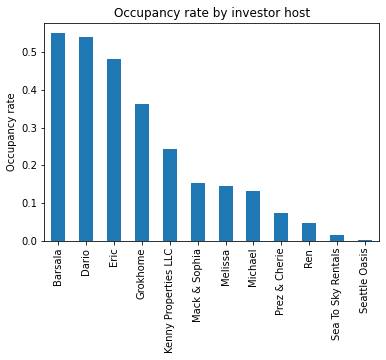

In [26]:
investor_availability[['host_name', 'occupancy_rate']].sort_values(by='occupancy_rate', ascending=False).plot(kind='bar', legend=None)
x = investor_availability['host_name'].unique()
x_pos = [i for i, _ in enumerate(x)]
plt.xticks(x_pos, x);
plt.xlabel('');
plt.ylabel('Occupancy rate');
plt.title('Occupancy rate by investor host');

<h3>Model</h3>

**Plotting investor vs. non-investor owned listing occupancy rates**

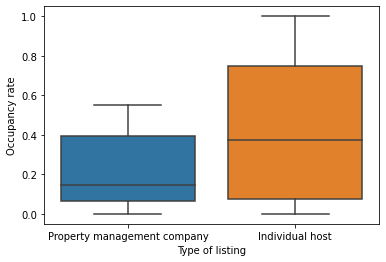

In [27]:
import seaborn as sns

boxplot_df = pd.concat([investor_availability['occupancy_rate'], noninvestor_availability['occupancy_rate']], axis=1)
boxplot_df.columns = ['Property management company', 'Individual host']

bp = sns.boxplot(x="variable", y="value", data=pd.melt(boxplot_df));
bp.set(xlabel="Type of listing", ylabel="Occupancy rate");


<h3>Evaluation</h3>

**Testing for difference in mean occupancy rates between investor and non-investor groups**

In [28]:
# Because we are only dealing with two groups, we can use a t-test.
# We will use the independent variant of the t-test since our a priori assumption is that the occupancy rates of the 
# investor and non-investor groups are independent

# First, import the requisite library/module:

from scipy.stats import t, ttest_ind

# Set parameter equal_var=False because the groups don't have equal variance (from boxplot)
t_test_result = ttest_ind(investor_availability['occupancy_rate'], noninvestor_availability['occupancy_rate'], equal_var=False)

# Retrieve the degrees of freedom:
dof = len(investor_availability['occupancy_rate']) + len(noninvestor_availability['occupancy_rate']) - 2

# Desired confidence level:
p = 0.99

# Critical t value:
t_crit = t.ppf(p, dof)

print('''

Null hypothesis

H0: Investor mean occupancy rate = Non-investor mean occupancy rate

Alternative hypothesis

H1: Investor mean occupancy rate < Non-investor mean occupancy rate

Degrees of freedom: {}
Confidence level: {}%
Critical t-value: {:.3f}
'''.format(dof, p*100, t_crit))

t_stat = t_test_result[0]
p_val = t_test_result[1]

(print('''The t-value is {:.3f} and the associated p-value is {:.3f}. A one-sided t-test gives a p-value of p_val/2, or {:.3f}.
As the absolute value of the t-statistic is greater than the critical t-value {:.3f}, we reject the null hypothesis in favor of the alternative hypothesis.
We can conclude that there is a statistically significant, positive, difference between the occupancy rates of noninvestor-hosted versus 
investor-hosted Airbnb listings. Over the course of 2016, our data tells us that noninvestor-hosted listings have consistently better occupancy rates
than investor-hosted listings, by 19 percentage points on average.'''.format(t_stat, p_val, p_val/2, t_crit)))



Null hypothesis

H0: Investor mean occupancy rate = Non-investor mean occupancy rate

Alternative hypothesis

H1: Investor mean occupancy rate < Non-investor mean occupancy rate

Degrees of freedom: 2336
Confidence level: 99.0%
Critical t-value: 2.328

The t-value is -3.127 and the associated p-value is 0.009. A one-sided t-test gives a p-value of p_val/2, or 0.005.
As the absolute value of the t-statistic is greater than the critical t-value 2.328, we reject the null hypothesis in favor of the alternative hypothesis.
We can conclude that there is a statistically significant, positive, difference between the occupancy rates of noninvestor-hosted versus 
investor-hosted Airbnb listings. Over the course of 2016, our data tells us that noninvestor-hosted listings have consistently better occupancy rates
than investor-hosted listings, by 19 percentage points on average.
